## Classification accuracy by population size

This notebook implements the simulations described in Jwa et al. to simulate the effects of population size on classification accuracy. The simulations are based on the results of [Schwartz et al., 2021](https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/33582276/), though here we use a simple nearest neighbor
classifier to demonstrate the drop in accuracy as a function of population size for a sample-to-population attack (i.e. attempting to reidentify specific individuals from a larger population within an anonymized dataset).

The simulations here are based on accuracy rates reported by Schwartz et al. for images defaced using pydeface:

- 16/157 (10%) without refacing
- 59/157 (38%) with reconstruction using mri_reface

The present simulations are not meant to simulate the actual process of face recognition, but rather to demonstrate how accuracy decreases systematically with population size in this form of attack.

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import torch
import time

use_cuda = torch.cuda.is_available()

try:
    import faiss
except:
    if use_cuda:
        !pip install faiss-gpu --no-cache
    else:
        !pip install faiss-cpu --no-cache        
    import faiss

if use_cuda:
    # use GPU if available
    res = faiss.StandardGpuResources()
    print('GPU available:', use_cuda)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 21.0 MB/s eta 0:00:0031m14.7 MB/s eta 0:00:01


First we create some functions to implement a [fast method for nearest-neighbor classification](https://towardsdatascience.com/make-knn-300-times-faster-than-scikit-learns-in-20-lines-5e29d74e76bb) and to perfom the classification on a dataset using a version of the same datset with noise added. The classification target is simply a set of integers for each data point; thus, classification accuracy is the average accuracy of identifying any individual in the dataset from the full population.


In [2]:
class FaissKNeighbors:
    """
    use faiss to implement fast KNN: 
    Based on: 
    """
    def __init__(self, k=1):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        if use_cuda:
            # use GPU if available
            self.index = faiss.index_cpu_to_gpu(res, 0, self.index)
        self.index.add(X.astype(np.float32))
        self.y = y


    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


def nn_test(data, noise_scale, rng=None):
    """
    A function that takes a dataset, fits a nearest neighbor classifier,
    and then classifies observations generated by adding noise to the
    original data.

    inputs:
    data (ndarray): original data, population size X n features
    noise_scale (scalar): standard deviation of added noise
    rng: numpy random noise generator

    return:
    accuracy of resulting classification
    """

    if rng is None:
        rng = np.random.default_rng(None)
    target = np.arange(data.shape[0])
    nn = FaissKNeighbors()
    nn.fit(data, target)
    data_noised = data + rng.normal(scale=noise_scale, size=data.shape)
    return nn.score(data_noised, target)


## Rationale

We want to generate data for which a classifier (in this case a one-nearest-neighbor) will give a particular level of accuracy for the population size (157) used in the Schwarz et al. paper. Then we will use that same noise level to generate a larger population for which we will test classification accuracy.

We first need to determine, for a given level of accuracy, what the noise level is that would give that level of accuracy (on average). Initial testing suggested that the range of noise levels from 2.5 to 20 was sufficient to capture the range from maximum to minimum accuracy. We run a large number of simulations using noise values sampled randomly from that range, and then use a polynomial regression to estimate the relationship between noise level and accuracy.

In [3]:
def get_accuracy_by_noise_level(npts, nfeatures, noise_range=None, seed=None):
    if noise_range is None:
        noise_range = [2.5, 20]
    rng = np.random.default_rng(seed)
    results = []
    for i in range(10000):
        noise_scale = rng.random() * np.diff(noise_range)[0] + noise_range[0]
        data = rng.normal(scale=1, size=(npts, nfeatures))
        nn_test_result =  nn_test(data, noise_scale, rng)
        results.append([noise_scale, nn_test_result])
    return pd.DataFrame(results, columns=['noise_sd', 'accuracy'])

npts = 157  # population size for Schwartz
nfeatures = 100

start = time.perf_counter()
results_df = get_accuracy_by_noise_level(npts, nfeatures)
time.perf_counter() - start

5.787442250060849

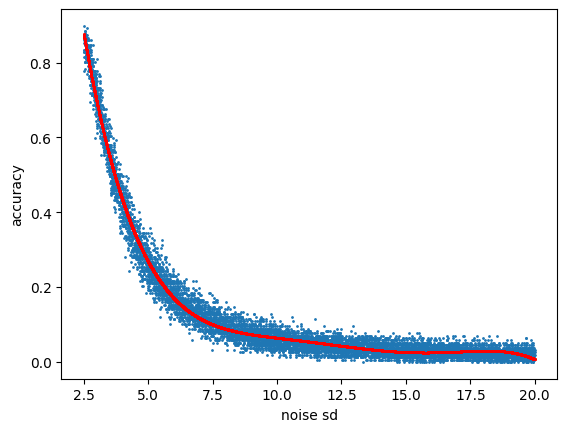

In [4]:
# fit nonlinear function to results to get predicted accuracy and save to results_df
def get_predicted_accuracy_by_noise(results_df):
    poly = PolynomialFeatures(5)
    X = poly.fit_transform(results_df[['noise_sd']])
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, results_df.accuracy)
    results_df['predicted'] = lr.predict(X)
    plt.scatter(results_df.noise_sd, results_df.accuracy, s=1)
    plt.scatter(results_df.noise_sd, results_df.predicted, color='red', s=1)
    plt.xlabel('noise sd')
    plt.ylabel('accuracy')
    return results_df

results_df = get_predicted_accuracy_by_noise(results_df)

The following is the main simulation, in which we vary population size to determine how classification accuracy decreases as a function of population size.  We first generate a dataset of individuals.  We then perform the analysis for the two levels of accuracy described above, varying across a range of population sizes from 157 (the population size in the Schwarz paper) up to 500,000. Random seeds were chosen manually for each accuracy level such that they give accuracy results for n=157 that are within 1% of the reported value.


In [5]:
def get_noise_level(target_accuracy, results_df):
    """
    A function to estimate the noise level needed to obtain
    a particular level of classification accuracy

    inputs:
    target_accuracy (float): desired accuracy
    results_df (DataFrame): data frame containing simulation results

    returns:
    noise level to give desired accuracy
    """
    absdiff = np.abs(results_df.predicted - target_accuracy)
    return results_df.loc[np.argmin(absdiff), 'noise_sd']


We will use a range of population sizes ranging from the small population size used in Schwartz et al. to the estimated population size for a moderately sized US city with a broad age range across both genders.

In [6]:
pop_sizes = [157, 250, 500, 1000, 5000, 6500, 70000, 423000, 865000]
target_accuracy = [0.1, 0.38] # from Schwartz et al.

# create random feature values for the largest population size
# we will subsample these for smaller population sizes
rng = np.random.default_rng(12345)
popdata = rng.normal(size=(np.max(pop_sizes), nfeatures))


First we find the random seeds that will get us into the correct range for each target accuracy level within a tolerance range of 1% for the sample size in the Schwartz paper.


In [7]:
acc_seeds = {}
data_subset = popdata[:157, :]
tolerance = .01

for target_acc in target_accuracy:
    acc = -1
    target_noise = get_noise_level(target_acc, results_df)
    while np.abs(acc - target_acc) > tolerance:
        seed = np.random.randint(10000000)
        rng = np.random.default_rng(seed)
        acc = nn_test(data_subset, target_noise, rng)
    acc_seeds[target_acc] = seed
    print(target_acc, acc, seed)

0.1 0.09554140127388536 3458856
0.38 0.3885350318471338 8205135


Next we loop through each of the population sizes, using the random seed obtained above to ensure that the 

In [ ]:
def simulate_accuracy_by_population_size(results_df, popdata, acc_seeds, pop_sizes, 
                                         save_result=True):
    sim_results = []
    
    for target_accuracy in acc_seeds.keys():
        target_noise = get_noise_level(target_accuracy, results_df)
        for ps in pop_sizes:
            # reset rng with seed for each sample
            rng = np.random.default_rng(acc_seeds[target_accuracy])
            data_subset = popdata[:ps, :]
            result = nn_test(data_subset, target_noise, rng)
            sim_results.append([target_noise, ps, result])
            print([target_noise, ps, result])
    sim_results_df = pd.DataFrame(
        sim_results, columns=['target_noise', 'popsize', 'accuracy']
    )
    # labels for plotting
    sim_results_df['SignalNoiseRatio'] = [
        'high' if i < sim_results_df.target_noise.median() else 'low'
        for i in sim_results_df.target_noise
    ]
    if save_result:
        sim_results_df.to_csv('sim_results.csv')
    return sim_results_df

sim_results_df = simulate_accuracy_by_population_size(
    results_df, popdata, acc_seeds, pop_sizes)
    

[7.507717966848982, 157, 0.09554140127388536]
[7.507717966848982, 250, 0.068]
[7.507717966848982, 500, 0.048]
[7.507717966848982, 1000, 0.026]
[7.507717966848982, 5000, 0.011]
[7.507717966848982, 6500, 0.009230769230769232]
[7.507717966848982, 70000, 0.0019285714285714286]
[7.507717966848982, 423000, 0.00047990543735224587]


Finally, plot the relationship between target population size and classification accuracy on a log-log scale.

In [ ]:
def plot_accuracy(sim_results_df, save_fig=True):
    sns.lineplot(
        x='popsize', y='accuracy', hue='SignalNoiseRatio', data=sim_results_df
    )
    plt.xlabel('Target population size (log)')
    plt.ylabel('Classification accuracy (log)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    if save_fig:
        plt.savefig('accuracy_by_popsize.png')

plot_accuracy(sim_results_df)